In [1]:
import numpy as np
import matplotlib.pyplot as plt

from generate_chunks import load_data
from train_models import ModelTrainer
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
from itertools import combinations


In [10]:
# Load data and model
train_chunks, training_chunk_dates, test_chunks, test_chunk_dates = load_data()
model = ModelTrainer(f'configs/WAE_NOGAN.json').fit()

<Figure size 640x480 with 0 Axes>

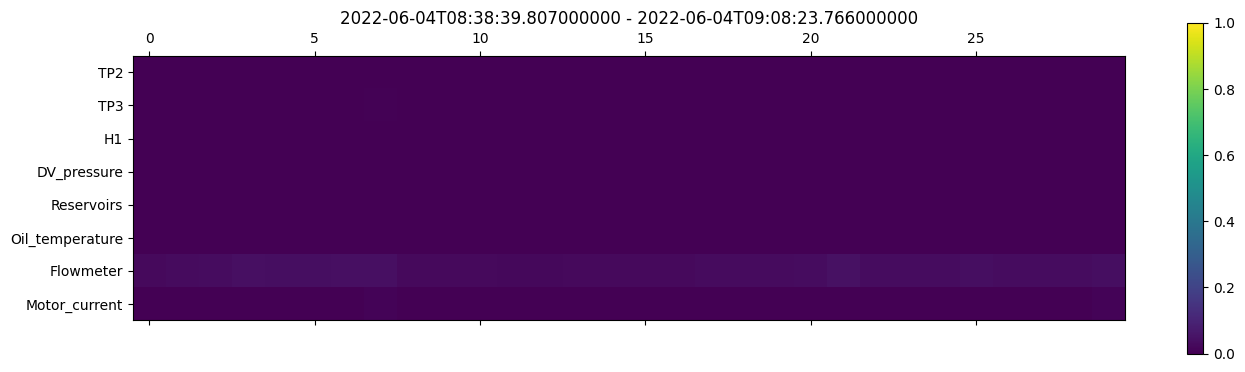

<Figure size 640x480 with 0 Axes>

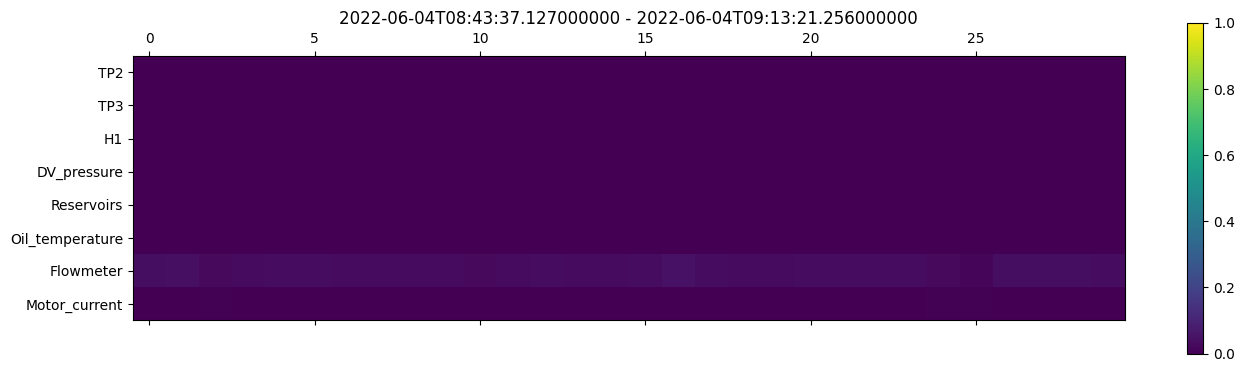

<Figure size 640x480 with 0 Axes>

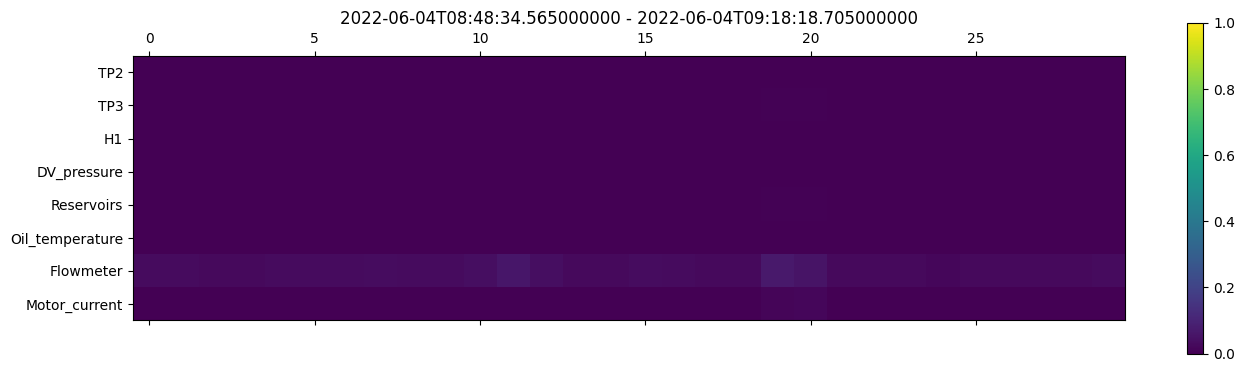

<Figure size 640x480 with 0 Axes>

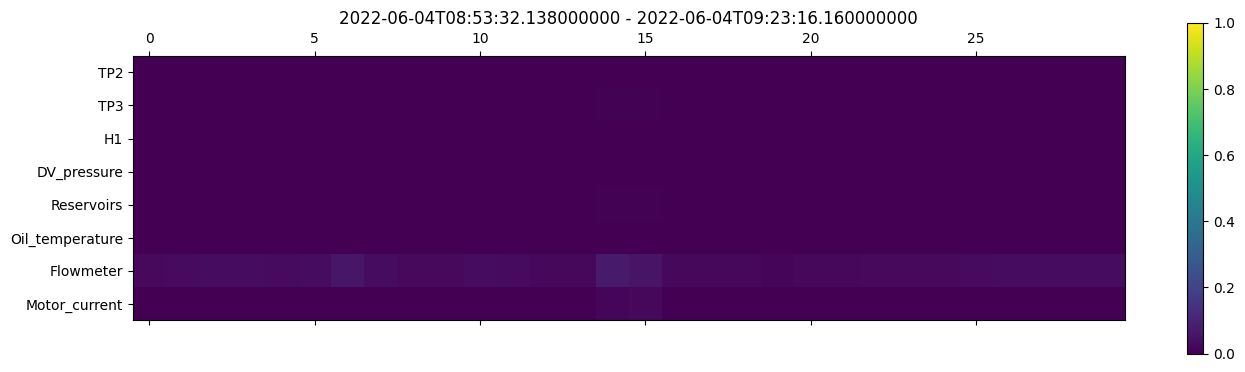

<Figure size 640x480 with 0 Axes>

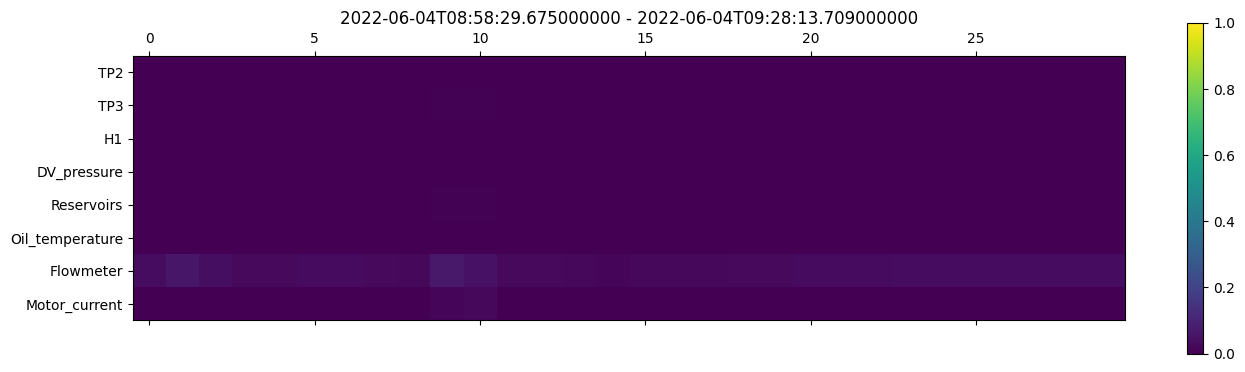

<Figure size 640x480 with 0 Axes>

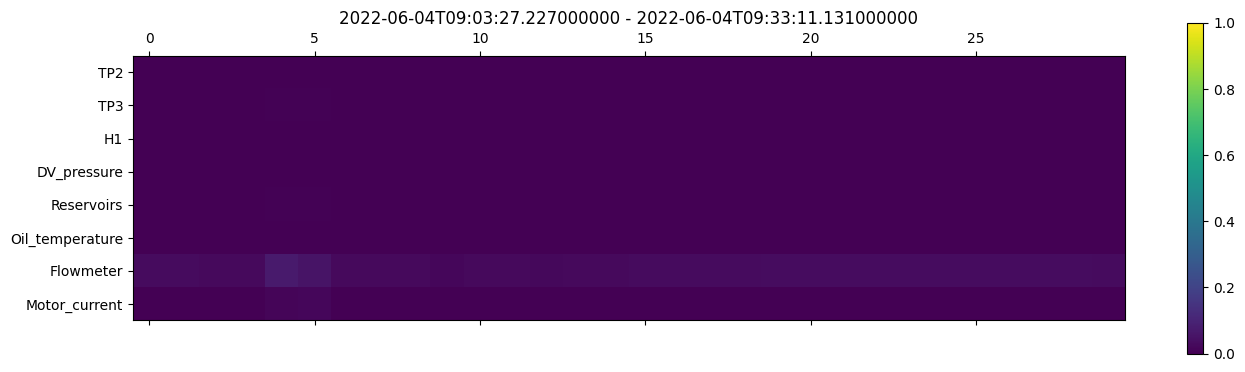

<Figure size 640x480 with 0 Axes>

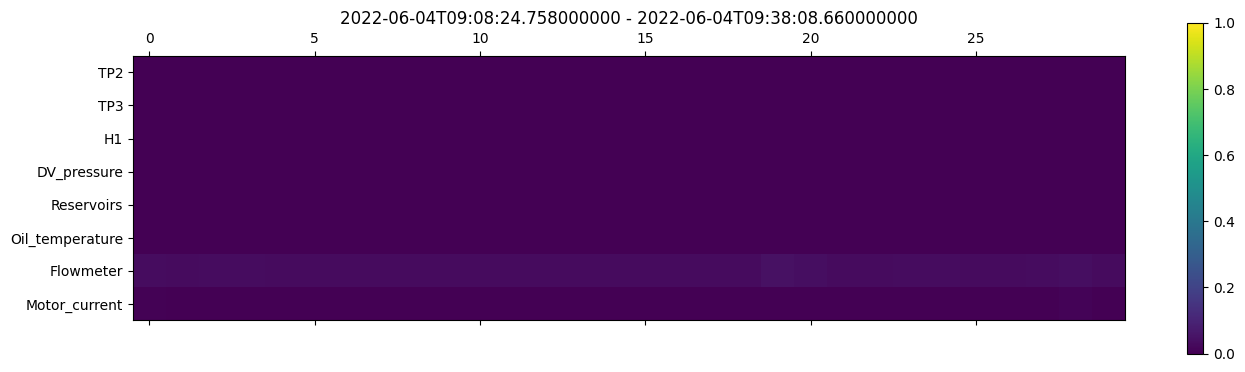

<Figure size 640x480 with 0 Axes>

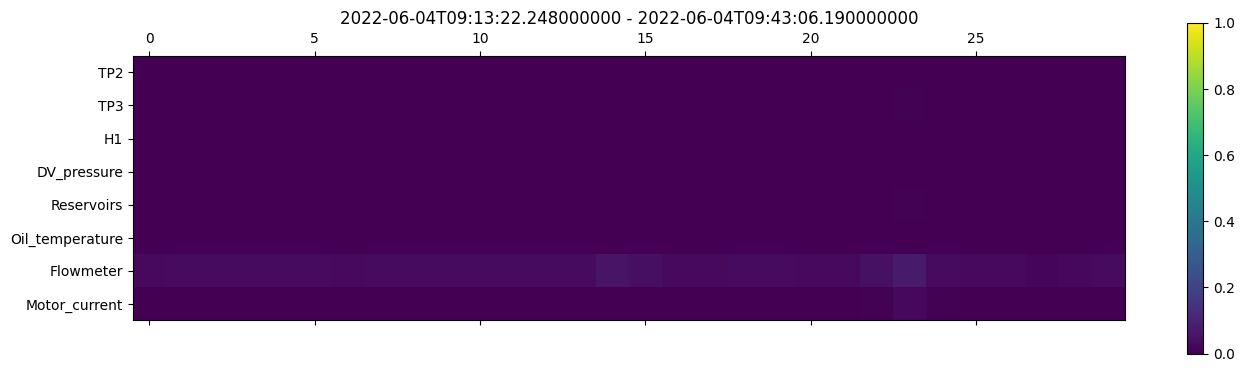

In [11]:
channel_names = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs','Oil_temperature', 'Flowmeter', 'Motor_current']

test_indices_to_check = np.array([898, 899, 900, 901, 902, 903, 904, 905])
# Get prediction
X = test_chunks[test_indices_to_check]
reconstructions = model.predict(X)
errors = model.calc_loss(X, X, average=False)

segment_size = 60 # One minute segments
mask = np.arange(1800).reshape(-1, segment_size)
error_summary = errors[:, mask].sum(axis=2) / errors.sum(axis=(1, 2)).reshape(-1, 1, 1)

for i in range(len(test_indices_to_check)):
    index = test_indices_to_check[i]
    test_range = test_chunk_dates[index]
    plt.figure()
    plt.matshow(error_summary[i].T, vmin=0, vmax=1)
    plt.yticks(ticks=np.arange(len(channel_names)), labels=channel_names)
    plt.colorbar()
    plt.title(f'{test_range[0]} - {test_range[1]}')


<Figure size 640x480 with 0 Axes>

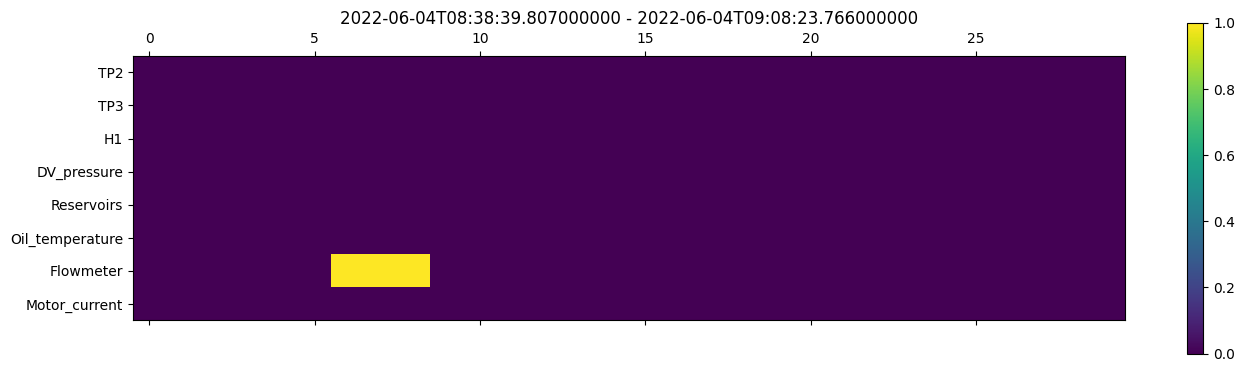

<Figure size 640x480 with 0 Axes>

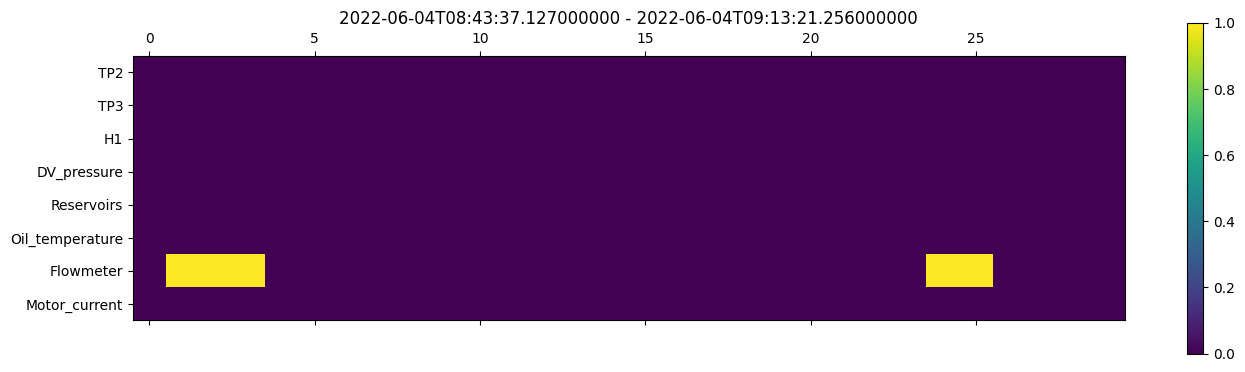

<Figure size 640x480 with 0 Axes>

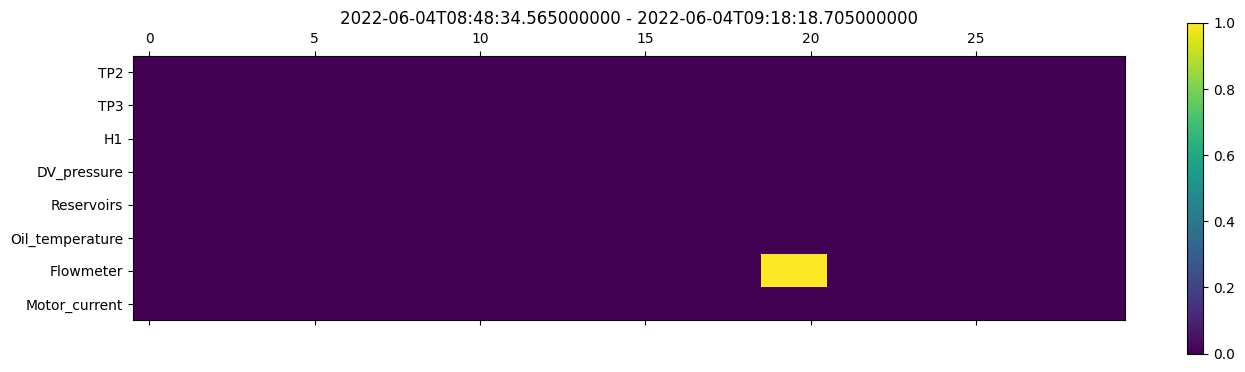

<Figure size 640x480 with 0 Axes>

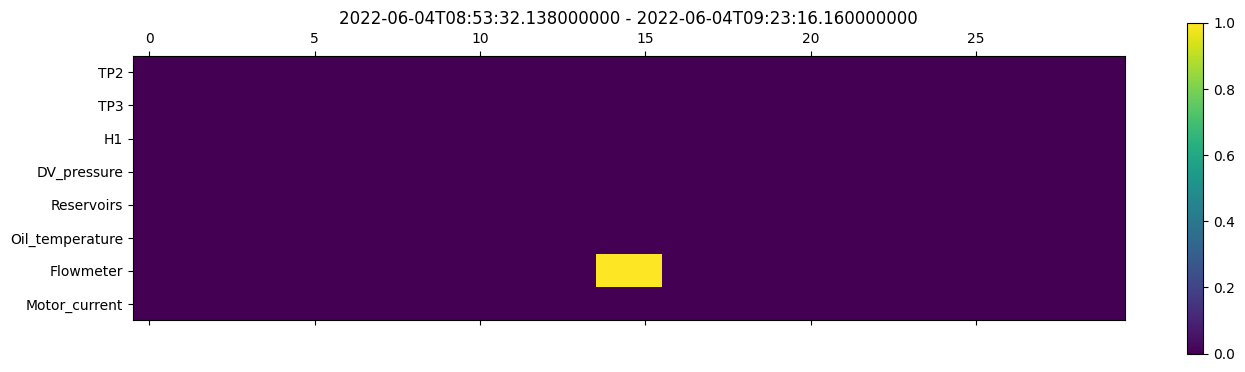

<Figure size 640x480 with 0 Axes>

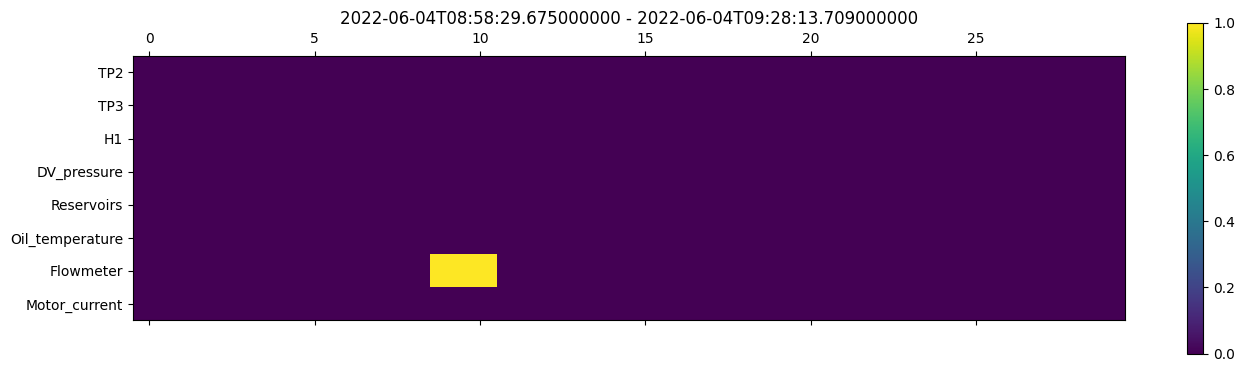

<Figure size 640x480 with 0 Axes>

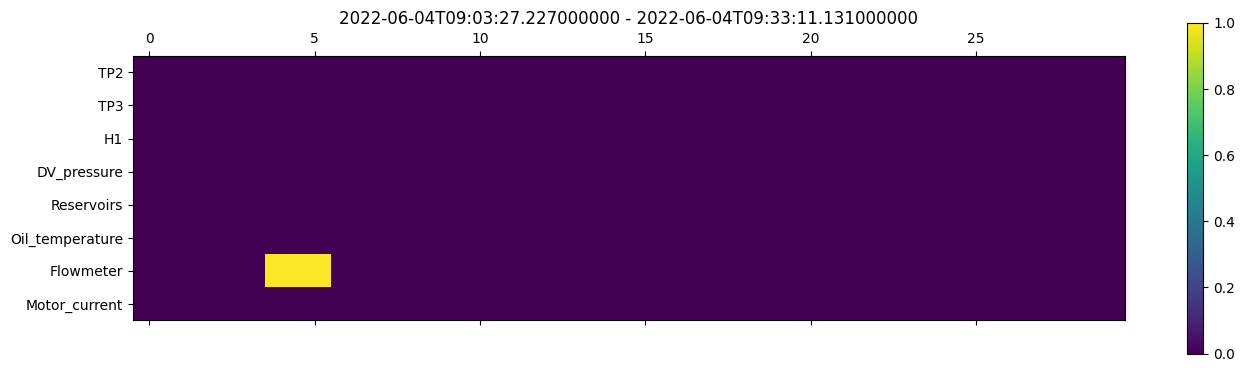

<Figure size 640x480 with 0 Axes>

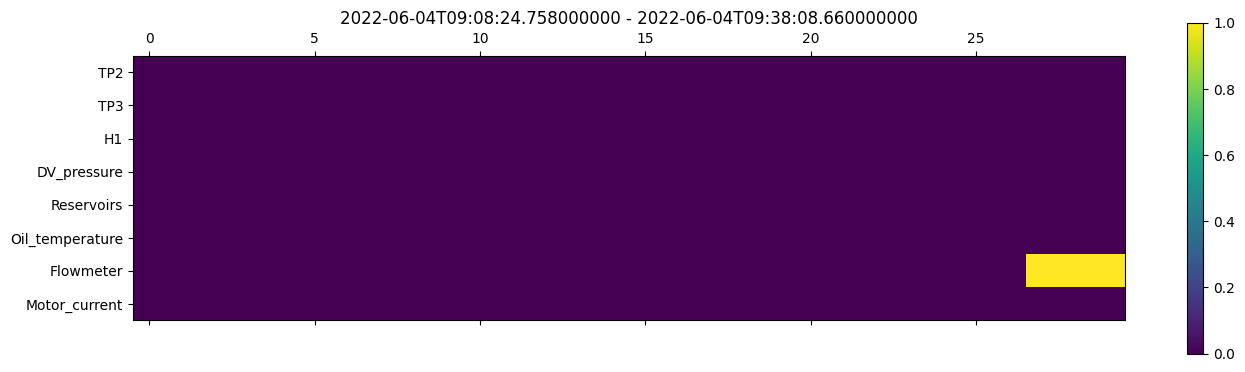

<Figure size 640x480 with 0 Axes>

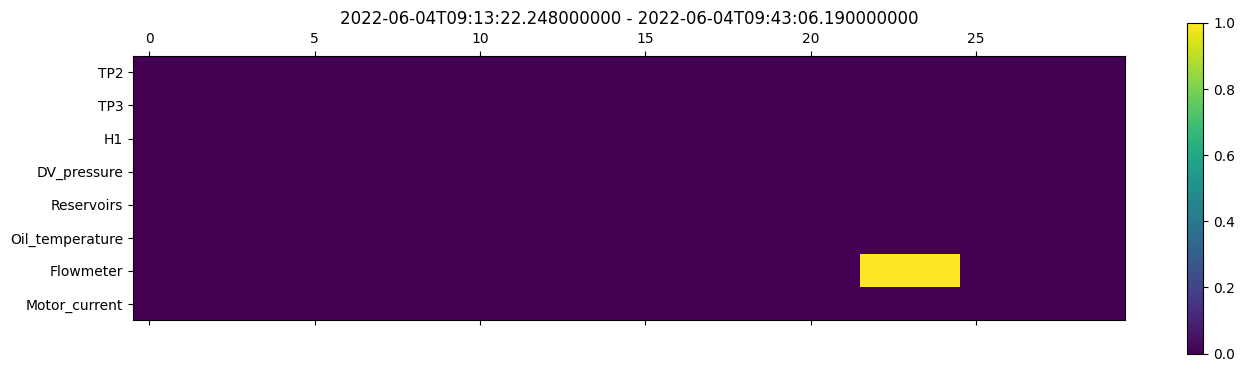

In [4]:
def find_connected_components(E, theta=None, return_2d=True):
    if theta is None:
        theta = E.max() * 0.1

    C = E.shape[0]
    T = E.shape[1]
    edges = np.zeros((T * C, T * C))

    for t in range(T):
        
        ## Connect if two channels are above threshold
        c = np.where(E[:, t] > theta)[0] * T + t
        
        for i1, i2 in combinations(c, 2):
            edges[i1, i2] = 1

        ## Connect if two consecutive timestamps are above threshold
        if t > 0:
            curr_slice = E[:, t] > theta
            prev_slice = E[:, t-1] > theta
            c = np.where(np.logical_and(curr_slice, prev_slice))[0] * T + t
            for _c in c:
                edges[_c, _c-1] = 1

    n_components, labels = connected_components(csr_matrix(edges), directed=False)
    components = []
    for i in range(n_components):
        elements = (labels == i).sum()
        if elements > 1:
            components.append(np.where(labels==i)[0])

    components_2d = []
    for component in components:
        y = component // T 
        x = component % T 
        components_2d.append(np.array(list(zip(x, y))))
    if return_2d:
        return components_2d
    return components

for i in range(len(test_indices_to_check)):
    index = test_indices_to_check[i]
    test_range = test_chunk_dates[index]
    E = error_summary[i].T
    components_2d = find_connected_components(E, theta=0.01)
    mask = np.zeros_like(E)
    for component in components_2d:
        mask[component[:, 1], component[:, 0]] = 1

    plt.figure()
    plt.matshow(mask, vmin=0, vmax=1)
    plt.yticks(ticks=np.arange(len(channel_names)), labels=channel_names)
    plt.colorbar()
    plt.title(f'{test_range[0]} - {test_range[1]}')



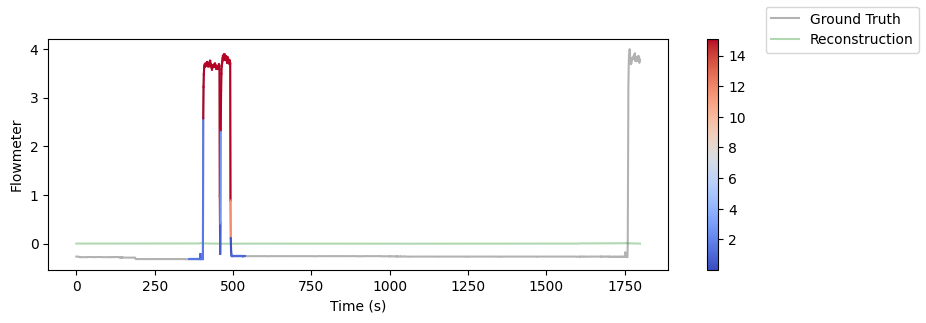

In [5]:
# Plot true data with error

# Returns (n_components, n_involved_channels, 3), where the last dimension has (start, end, channel) tuple
def get_regions(components, segment_size):
    n_components = len(components)
    component_indices = []
    for component in components:
        indices = []
        # Get all involved channels
        channels = np.sort(np.unique(component[:, 1]))
        for channel in channels:
            boundaries = component[np.where(component[:, 1] == channel)[0], 0]
            start = boundaries[0] * segment_size
            stop = (boundaries[-1] + 1) * segment_size
            indices.append([start, stop, channel])

        component_indices.append(np.array(indices))

    component_indices = np.array(component_indices)
    assert component_indices.shape[0] == n_components
    assert component_indices.shape[2] == 3

    return component_indices

def visualize_region(regions, data, prediction, error):
    channels = np.unique(regions.reshape(-1, 3)[:, 2])
    fig, axs = plt.subplots(len(channels), 1, squeeze=False, figsize=(10, 2+(len(channels))))
    channel_mapping = {channel_number: index for index, channel_number in enumerate(channels)}
    cmap = plt.get_cmap('coolwarm')
    min_err = 1e9
    max_err = 0
    for (start, stop, channel) in regions.reshape(-1, 3):
        _data = data[start:stop, channel]
        _err = error[start:stop, channel]
        min_err = min(min_err, _err.min())
        max_err = max(max_err, _err.max())
        ax = axs.ravel()[channel_mapping[channel]]
        # Plot data
        ax.plot(data[:, channel], color='black', alpha=0.3, label='Ground Truth')
        # Plot prediction
        ax.plot(prediction[:, channel], color='green', alpha=0.3, label='Reconstruction')
        for i in range(len(_data)-1):
            ax.plot([start+i, start+i+1], _data[i:i+2], color=cmap(_err[i]))
        ax.set_ylabel(channel_names[channel])
        ax.set_xlabel('Time (s)')

    norm = plt.Normalize(min_err, max_err)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    for i in range(len(channels)):
        fig.colorbar(sm, ax=axs.ravel()[i])
    fig.legend()

for i in range(len(test_indices_to_check)):
    if i != 0:
        continue
    index = test_indices_to_check[i]
    test_range = test_chunk_dates[index]
    data = test_chunks[index]
    es = error_summary[i].T
    components_2d = find_connected_components(es, theta=0.01)
    regions = get_regions(components_2d, segment_size)
    prediction = reconstructions[i]
    visualize_region(regions, data, prediction, errors[i])


# Investigate why Flowmeter is such a good predictor of error

(4437000, 8) (2465,)
1800.0
<class 'str'>


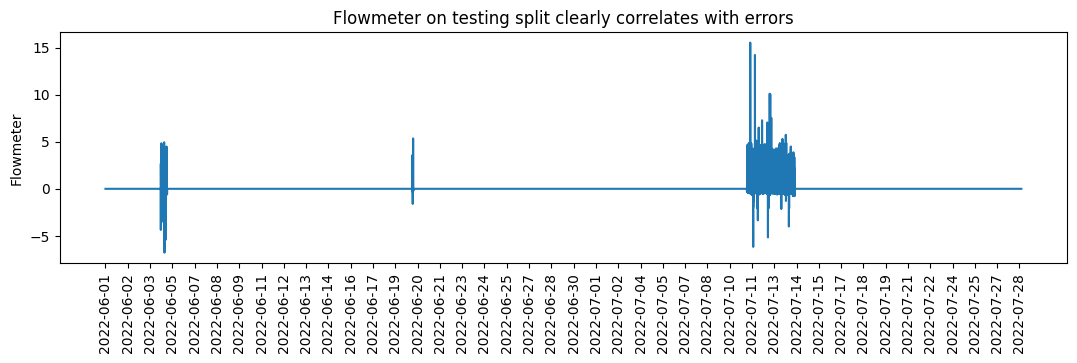

In [6]:
test_data = test_chunks[::6].reshape(-1, len(channel_names))
test_dates = test_chunk_dates[::6].reshape(-1, 2)[:, 0]

print(test_data.shape, test_dates.shape)
print(test_data.shape[0] / test_dates.shape[0])

plot_every = 60
x_ticks = np.arange(0, test_data.shape[0], 1800*plot_every)
plt.figure(figsize=(13, 3))
plt.plot(test_data[:, 6])
# Format x labels
x_labels = test_dates[::plot_every]
x_labels = [str(l)[:10] for l in x_labels]
plt.xticks(x_ticks, x_labels, rotation=90)
plt.ylabel('Flowmeter')
plt.title('Flowmeter on testing split clearly correlates with errors')
print(type(x_labels[0]))

[[2.21406482e-03 1.07625592e-02 6.72143011e-04 1.71076867e-03
  8.70042574e-03 3.30009591e-03 9.43484962e-01 2.91550141e-02]
 [1.74694462e-03 9.64499451e-03 6.36436162e-04 1.29908265e-03
  7.50675658e-03 3.37177352e-03 9.52882290e-01 2.29123123e-02]
 [2.58686207e-03 1.33355651e-02 9.12120158e-04 2.28489377e-03
  1.06326127e-02 4.01753793e-03 9.28359687e-01 3.78701203e-02]
 [2.71414872e-03 1.34743415e-02 9.57087555e-04 2.27740919e-03
  1.08069880e-02 4.00720350e-03 9.27622020e-01 3.81409004e-02]
 [2.79674563e-03 1.34113068e-02 9.42876970e-04 2.26572575e-03
  1.07413726e-02 4.02036402e-03 9.27342951e-01 3.84794548e-02]
 [2.81178509e-03 1.36754382e-02 9.65086801e-04 2.60412274e-03
  1.08577870e-02 4.04785760e-03 9.27520514e-01 3.75176184e-02]
 [1.80182140e-03 1.09775262e-02 7.13489717e-04 1.44797808e-03
  8.32262449e-03 3.49546247e-03 9.45900202e-01 2.73409393e-02]
 [2.15885090e-03 1.32922856e-02 9.72706650e-04 2.04557087e-03
  1.03133358e-02 3.53766629e-03 9.29273725e-01 3.84069271e-02]]

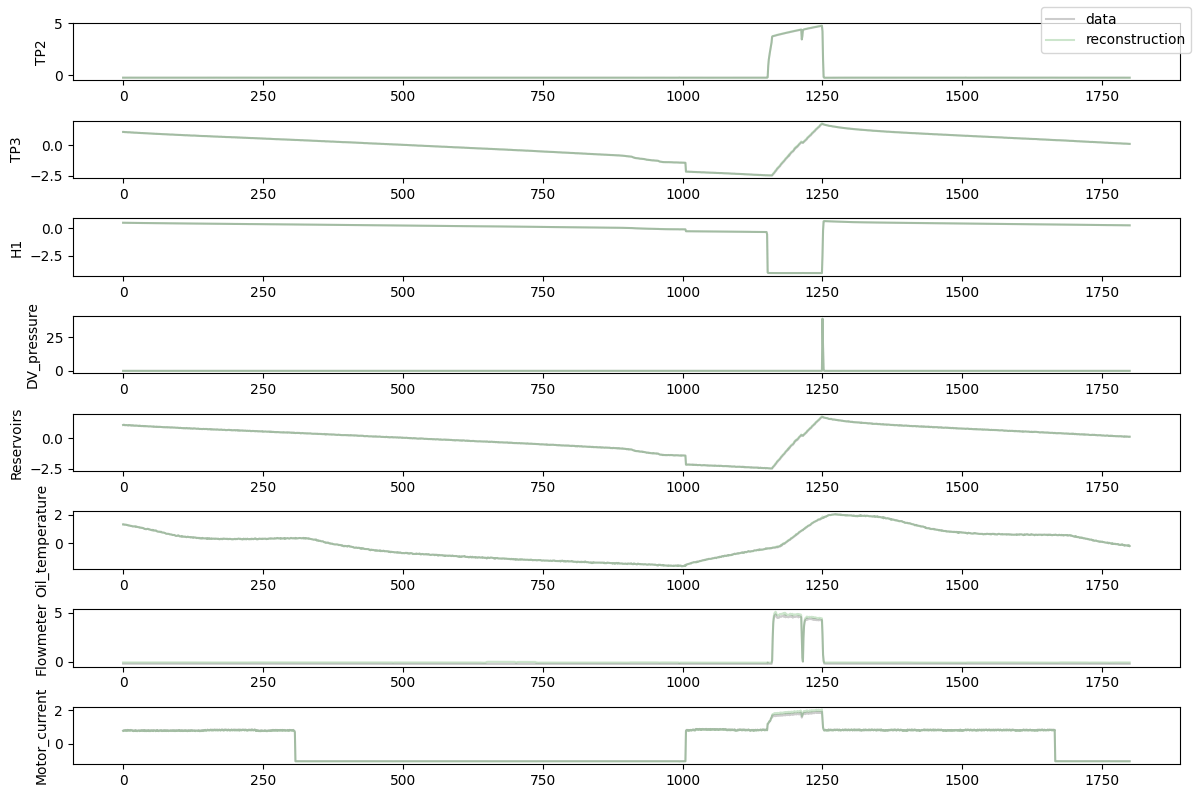

In [31]:
model = ModelTrainer(f'configs/WAE_NOGAN.json').fit()
test_indices_to_check = np.array([898, 899, 900, 901, 902, 903, 904, 905])
channel_names = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs','Oil_temperature', 'Flowmeter', 'Motor_current']
# Get prediction
X = test_chunks[test_indices_to_check]
reconstructions = model.predict(X)
errors = model.calc_loss(X, X, average=False)
error_sum = errors.sum(axis=(1, 2)).reshape(-1, 1)
print(errors.sum(axis=1) / error_sum)

fig, axs = plt.subplots(8, 1, figsize=(12, 8))
d_idx = 2
#X = X[..., [0, 1, 2, 3, 4, 5, 7]]
for i in range(8):
    axs.ravel()[i].plot(X[d_idx, :, i], color='black', alpha=0.2, label='data' if i == 0 else '')
    axs.ravel()[i].plot(reconstructions[d_idx, :, i], color='green', alpha=0.2, label='reconstruction' if i == 0 else '')
    axs.ravel()[i].set_ylabel(channel_names[i])
fig.tight_layout()
fig.legend()